## Overview
This notebook estimates the more computationally expensive model (those that I could not train within 1-2 days on my laptop). I pursue four strategies to make estimating these models feasible: Firstly, running this bookbook on AWS EC2 lets me take advantage of more powerful hardware. Secondly, I used a single validation set rather than 5-fold cross-validation, which cuts computational time by a factor of 5. In addition, I use only a subset of observations (40,000 to 80,000, i.e. 5-10% of the training set).  Finally, for some of the models, I reduce the dimensionality of the features space using principal components analysis, which allowed using a larger number of observations (80,000).

## Load packages and data

In [1]:
import pdb 
import glob
import copy
import math
import pickle
import csv

import boto3
import uuid
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, StratifiedShuffleSplit, ShuffleSplit, \
    cross_val_score, StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_score, recall_score, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

We will use Boto 3 again to interact with S3 from our notebook.

In [14]:
# Create boto3 resource to interact with S3
s3 = boto3.resource('s3')

In the previous notebook, we uploaded our preprocessed data from the local machine to a S3 bucket. Let's now download these data to our EC2 instance.

In [15]:
# Create folder to store data
!mkdir data_processed  

# Download files from S3 bucket
bucket_name = 'lending-club-a7b2c3e3-07f7-4444-b258-5bb63c282398'
filenames = ['X_train', 'X_test', 'y_train', 'y_test', 'feature_names']
for filename in filenames:
    s3.Object(bucket_name, f'{filename}.joblib') \
        .download_file(f'data_processed/{filename}.joblib')

mkdir: cannot create directory ‘data_processed’: File exists


Now we can load the data from disk.

In [16]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
feature_names = joblib.load('data_processed/feature_names.joblib')

In [17]:
np.mean(np.apply_along_axis(np.mean,1,X_train))

0.16258930635240712

In [19]:
y_test.shape

(153499,)

Since the full data set is too large to fit a SVM with RBF or polynomial kernel, we create smaller subsets with 50,000 observations for the training set (only 10,000 of which will actually be used for training, the remaining will be used for validation).

In [3]:
# Create smaller subsets from data for SVMs
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=50000, random_state=1)

## Dimensionality Reduction

Another step to make the models less computationally expensive is to reduce the dimensionality of the data set.  To that end, let's perform principal component analysis to determine whether the data lie in a lower dimensional subspace. 

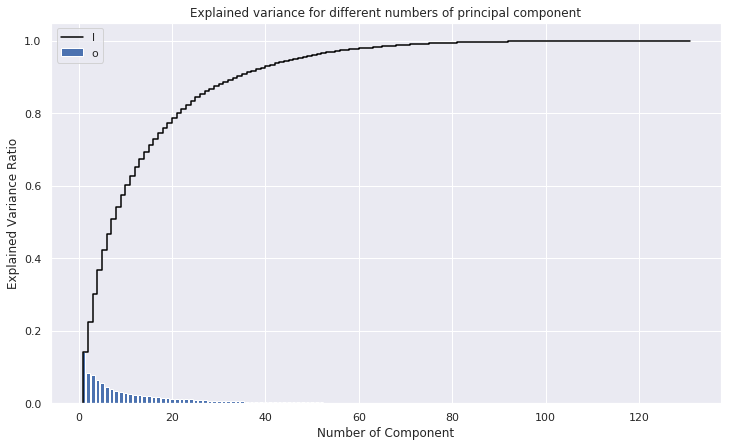

In [18]:
# Use PCA to assess whether features lie in lower-dimensional subspace
pca = PCA()
pca.fit(X_train)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Cumulative and per-component explained variance')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

The above plot shows the explained variance for principal component (blue bars), as well as the cumulative explained variance. This reveals that the first 20 principal components explain about 80% of the variance, and the first 50 principal components explain roughly 95% of the variance. 

I thus decide that the first 30 principal components, which explain close to 90% of the variance, give a good-enough lower-dimensional representation of the data. This reduction number of dimensions by over three quarters should make the models considerably faster to train.

In [24]:
# Project data onto the first 30 principal components
pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train) 
X_test_pc = pca.transform(X_test)

# Create smaller subsets from principal components
X_train_pc_s, y_train_pc_s = resample(
    X_train_pc, y_train,
    replace=False, n_samples=100000, random_state=1)

## Predictive models

We will again define dictionaries to hold important results from each model (average precision score, classification report, and future importance).

In [26]:
# Initialize dictionary to store average precision
average_precisions = {}

In [ ]:
# If it already (partially) exist, load it
average_precisions = joblib.load(
    'saved_models/average_precisions.joblib')

Before proceeding to train the models, I switch to a more powerful EC2 instance type. My decision on the most appropriate type was primarily based on two considerations:

First, note that the code will be single-threaded, because Hyperopt does not natively support parallelization.  For the other learners in the previous notebook, multi-threading was achieved through scikit-learn's cross validator class. Here however, I only use a *single* validation set, because I will be  training more computationally expensive models. Thus, it is worth trading a slightly higher variance in the validation score for considerable savings in computation.

Secondly, note that my models – SVM's with RBF and polynomial kernels – achieve a considerable speed-up if we dedicate a large amount of memory to them.

With these considerations in mind, I chose a r5.large instance, as it offered\s the largest amount of memory (16GB) and one of the highest computational capacities (9 ECUs) of all instances with one or two virtual CPUs. While one CPU would have been sufficient, none of these instances offered enough memory.

### SVM with RBF-Kernel

The strength of an SVM with an RBF kernel is in modeling *non-linear* relationships. Its weakness is that it does not scale well: According to scikit-learn's documentation, it is only recommended up to a couple tens of thousasands of observations. 

I will tune two hyperparameters, gamma and C. Let's think about what an appropriate prior year distribution for each of these would look like. For gamma, the neighborhood size, we will use a log-normal distribution. As mentioned in the previous note book, this distribution lets us concentrate probability mass on the most likely values in the center, but does so on a logarithmic scale. For the distribution's center, we use scikit-learn's default value, the inverse of the number of features. In our case this amounts to 1/130 for the full data set and 1/30 for the principal components. One potential point of confusion is that – as mentioned in a previous notebook – hyperopt uses the *natural* exponential function, whereas np.logspace (which we would often use with grid search) uses base 10. Therefore, we use log(1/130) and log(1/30) as the center parameter.

Setting the variance parameter is less intuitive, so I simply experiment with different values and observe the location of median as well as the 5th and 95th percentile. I choose 3, which results in most values falling within the commonly used range of 0.001 and 1000. 

Descriptive statistics:
 count    1.000000e+03
mean     9.456460e+00
std      1.577441e+02
min      2.745386e-07
5%       9.630072e-05
50%      2.852804e-02
95%      1.266645e+01
max      4.906266e+03
dtype: float64


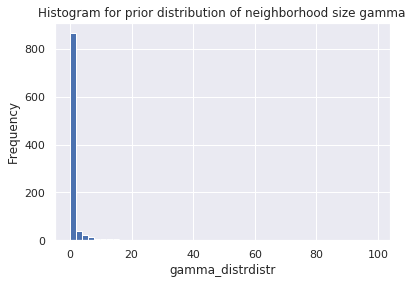

In [15]:
# Inspect prior distribution for gamma (Principal components)
gamma_distrdistr = hp.lognormal('C', np.log(1/30), 3.5)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Prior distribution of neighborhood size gamma')
plt.show()

Descriptive statistics:
 count    1.000000e+03
mean     1.303583e+01
std      3.178367e+02
min      9.825670e-09
5%       1.250487e-05
50%      9.169461e-03
95%      4.398888e+00
max      9.997066e+03
dtype: float64


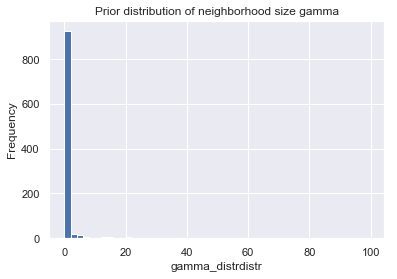

In [67]:
# Inspect prior distribution for gamma 
# (Original columns/no principal components)
gamma_distrdistr = hp.lognormal('C', np.log(1/130), 4)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Prior distribution of neighborhood size gamma')
plt.show()

For the regularization parameter C, we will also use a lognormal distribution. Since we want to center it at 1, we can simply pass a mean parameter of 0. To find the scale parameter, we experiment again to find reasonable values. Like for gamma, a common range is 0.001 to 1000. I choose a variance parameter of 5, but will later set an upper boundary of 10, which is usually large enough, because larger values take longer to train (up to an order of magnitude).  Since log-normal distributions are characterized by large positive outliers, and since the model is already computationally expensive, setting this upper threshold is useful.  As discussed in a previous notebook, hyperopt does not support setting upper or lower bounds by default.  Therefore, I add a function that adjusts the samples before passing them to the optimization, as well as before using the optimal parameters in other ways. If this threshold turns out to be too low, we will easily notice because the optimal value will be at the threshold. In this unlikely case, we will simply reestimate the model with gamma confined between 10 and 1000.

In [ ]:
# Inspect prior distribution for C
c_distr = hp.lognormal('C', 0, 3)
samples = [pyll.stochastic.sample(c_distr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(
          percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting
samples = list(filter(lambda x: x<100, samples))
# Plot
pd.Series(samples).plot(kind='hist', bins=50)
plt.xlabel('c_distr')
plt.title('Prior distribution of regularization strength')
plt.show()

This is the function that adjusts the parameters, making sure that C is not larger than 10:

In [14]:
def adjust_params_svm_rbf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Set min or max thresholds for parameters, where applicable
    if params['C'] >= 10:
        params['C'] = 10
        
    # Return modified parameters
    return params

Now we can combine the prior distributions specified above with other parameters we want to pass to the learner. Since the classes are imbalanced, we tell the classifier to adjust the weights accordingly. We also specify a much larger kernel size than default in order to speed up learning. (I Initially tried even higher values to take full advantage of the available RAM, but experienced instability of the Python kernel.)

In [ ]:
# PRINCIPAL COMPONENTS
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000, # 10GB
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/30), 3.5)}

Now let's define a function that carries out the Bayesian hyperparameter optimization, as explained in more detail in the previous notebook:

In [15]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""
        
        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)
    # Adjust best parameters, if specified
    if adjust_params is not None:
        best_params = adjust_params(best_params)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [ ]:
# Create directories to store models and progress files
!mkdir hp_progress saved_models

In [22]:
# Calculate average precision
def return_save_ap(clf, model_name, X_test, y_test, 
                  X_train, y_train, validation_plot=False):
    """
    Returns, saves, and prints average precision score on train and test set; 
    saves score, As well as predictions, from *test* set. Optionally plots how 
    average precision changed over iterations (designed for hyperopt).
    """

    # Predict class
    y = clf.predict(X_test)
    # Save class prediction
    joblib.dump(y, f'predictions_test/y_{model_name}.joblib')
    
    # Predict class probabilities
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
        y_score_train = clf.predict_proba(X_train)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
        y_score_train = clf.decision_function(X_train)
       
    # Save predictions for test set
    joblib.dump(y_score, f'predictions_test/y_score_{model_name}.joblib')
    
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    ap_score_train = average_precision_score(y_train, y_score_train)
    
    # Print AP
    print('Best average precision score on *test* set: {:.4f}' \
              .format(ap_score))
    print('Best average precision score on *training* set: {:.4f}' \
              .format(ap_score_train))
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance during Cross-Validation')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');
        
    # Return average precision
    return ap_score

We are now ready to estimate the model. We will try two different versions, one using 80,000 observations from the principal components, and one using 40,000 observations with the original variables.

### With principal components:

In [ ]:
# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_pc_hp',
              X_train=X_train_pc_s, y_train=y_train_pc_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)

In [20]:
# Load saved model from disk, if necessary
svm_rbf_pc_hp = joblib.load('saved_models/svm_rbf_pc_hp.joblib')

In [ ]:
# Create folder to store predictions for test set
! mkdir predictions_test

Best average precision score on *test* set: 0.3878
Best average precision score on *training* set: 0.3874


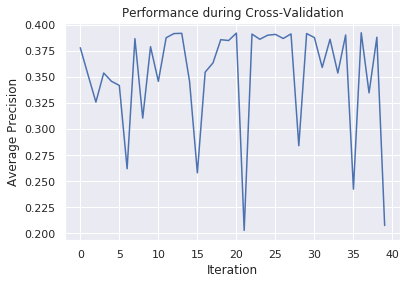

In [27]:
# Print and save average precision; save predictions
average_precisions['svm_rbf_pc'] = return_save_ap(
    svm_rbf_pc_hp, 'svm_rbf_pc_hp', X_test_pc, y_test,
    X_train=X_train_pc, y_train=y_train,
    validation_plot=True)

In [28]:
# Load predicted probability, if necessary
y_score_svm_rbf_pc = joblib.load('predictions_test/y_score_svm_rbf_pc_hp.joblib')

The test set average precision score of 0.388 is similar to – but slightly smaller than – what we got for logistic regression (.392) and random forests (.394). It is somewhat disappointing that we do not exceed the performance of logistic regression, which is very similar to a SVM with a *linear* kernel.  It seems that the greater flexibility of the RBF kernel to pick up nonlinear relationships is more than outweighed by the reduction in sample size we are forced to incur in order to make training the model computationally feasible. 

The next step is to adjust the decision threshold in order to get the hard predictions (class labels). 

In [29]:
# Define function to make a prediction with custom threshold
def custom_prediction(proba_or_dist, threshold):
    """
    Makes predictions for binary classification from probabilities or distance
    to separating hyperplane, given a custom threshold.
    """

    return (proba_or_dist > threshold).astype(int)


# Define function to plot effect of threshold on precision and recall
def plot_threshold(proba_or_dist, y_true=y_test, thresholds=None):
    """
    Plot precision and recall as a function of decision threshold for an array of
    probabilities or distances to separating hyperplane.

    If no custom list of thresholds is supplied, it defaults to a grid of length 
    100, spanning between the minimum and maximum probability/distance. (In
    order to avoid thresholds that assign all observations to a single class, 
    the smallest and largest thresholds are offset by 0.01 from the minimum and 
    maximum probability/distance.)

    Parameters
    ----------
    proba_or_dist: array-like
        Probabilities or distance from separating hyperplane
    y_true: array-like
        True values of target variable.
    thresholds: list-like
        Custom thresholds. Optional.  
        
    Returns
    -------
        None
    """
    
    # Initialize dictionaries to store results
    classes = {}
    precisions = {}
    recalls = {}
            
    # If no custom thresholds were passed, make grid between minimum and maximum
    # values for probability or distance.
    if thresholds is None:
        thresholds = np.linspace(proba_or_dist.min() + 0.01,
                                 proba_or_dist.max() - 0.01, 100)

    # Iterate over thresholds
    for threshold in thresholds:
        # Classify as 1 if probability/distance is greater than threshold, else 0
        classes[threshold] = custom_prediction(proba_or_dist, threshold)

        # Compute precision and recall
        precisions[threshold] = precision_score(y_true, classes[threshold])
        recalls[threshold] = recall_score(y_true, classes[threshold])

    # Combine precision and recall into a data frame, indexed by threshold
    pr_rec = pd.DataFrame({'precision': precisions, 'recall': recalls})

    # Plot results
    pr_rec.plot()
    plt.title('Effect of threshold on Precision and Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision\nRecall')
    plt.show()

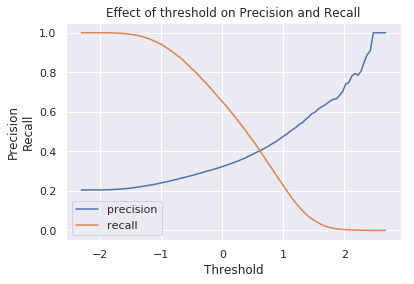

In [30]:
# Plot effect of decision threshold
plot_threshold(y_score_svm_rbf_pc)

This shows we need to set the decision the threshold at around 0.4.  Let's use this information to generate hard predictions.

In [46]:
# Make hard predictions
y_svm_rbf_pc_2 = custom_prediction(y_score_svm_rbf_pc, 0.4)
# Save new predictions to disk
joblib.dump(y_svm_rbf_pc_2, 'predictions_test/y_svm_rbf_pc_2.joblib')

['predictions_test/y_svm_rbf_pc_2.joblib']

In [47]:
# Get classification report 
print(classification_report(y_test, y_svm_rbf_pc_2))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82    122083
           1       0.37      0.50      0.42     31416

   micro avg       0.72      0.72      0.72    153499
   macro avg       0.61      0.64      0.62    153499
weighted avg       0.76      0.72      0.74    153499



We see that we achieved a recall of 0.5 and a precision of 0.37.

### With original features/no principal components

Because of this somewhat disappointing performance of the previous model, we'll reestimate the same model – a SVM with a RBF kernel – but using different features: Instead of the principal components, we will use the original features.  While these contain additional information that was lost during the dimensionality reduction, we are forced to cut our sample size in half to make up for the greater computational cost.  It's impossible to say beforehand if this trade-off is worth it, so we have to try to find out.

In [23]:
# Original columns/no principal components
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 10000,  # 10GB
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/130), 3.5)}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_s, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)

{'C': 10, 'cache_size': 10000, 'class_weight': 'balanced', 'gamma': 0.0005498849635490696, 'kernel': 'rbf'}


In [ ]:
# Load saved model from disk, if necessary
svm_rbf_hp = joblib.load('saved_models/svm_rbf_hp.joblib')

Let's take a look at the average precision score of our model:

Best average precision score on *test* set: 0.3983
Best average precision score on *training* set: 0.3972


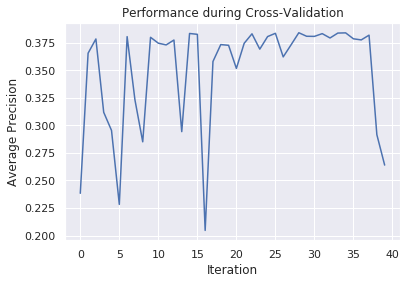

In [58]:
# Print and save average precision; save predictions
average_precisions['svm_rbf'] = return_save_ap(
    svm_rbf_hp, 'svm_rbf_hp', X_test, y_test,
    X_train=X_train, y_train=y_train,
    validation_plot=True)

Using the original features rather than the principal components gives us a considerable boost in accuracy from 0.386 to 0.398. This means that the model now performs a little better than logistic regression and random forests (though it is still far behind XGBoost's 0.414). Thus, it was worth we use more features rather than more observations.  
We will keep both versions for our final ensemble, though. The fact that the two versions use different predictors should de-correlate the prediction sufficiently to justify treating them as separate models (rather than weighing them each by, say, only 50%). 

Again, we want to adjust the decision the threshold for generating hard predictions:

In [ ]:
# Load predicted probability
y_score_svm_rbf = joblib.load('predictions_test/y_score_svm_rbf_hp.joblib')

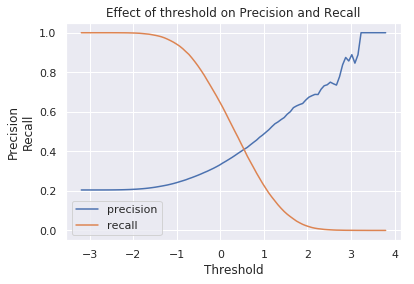

In [51]:
# Plot effect of decision threshold
plot_threshold(y_score_svm_rbf)

This time we pick a decision threshold of 0.35 in order to achieve our target recall of 0.5.

In [52]:
# Make hard predictions
y_svm_rbf_2 = custom_prediction(y_score_svm_rbf, 0.35)
# Save new predictions to disk
joblib.dump(y_svm_rbf_2, 'predictions_test/y_svm_rbf_2.joblib')

['predictions_test/y_svm_rbf_2.joblib']

In [53]:
# Get classification report 
print(classification_report(y_test, y_svm_rbf_2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82    122083
           1       0.38      0.50      0.43     31416

   micro avg       0.73      0.73      0.73    153499
   macro avg       0.62      0.64      0.63    153499
weighted avg       0.76      0.73      0.74    153499



### SVM with Polynomial Kernel

The last model we will train is a SVM with a polynomial kernel. Since the SVM with a RBF kernel achieved better performance using the original features rather using the principal components (even though this forced us to cut our training size), we will stick with the original data here. Like before, we use a training size of 40,000.

The hyperparameters we tune are again the regularization coefficient C, as well as the degree of the polynomial.  We keep the prior distribution of the former unchanged.  For the degree, we try the values 2, 3, 4, and assign equal prior probability to each. The trade-off for this hyperparameters is that higher degrees allow modeling more complex relationships, but they tend to behave erratically far away from the mean.

In [ ]:
# Original columns/no principal components
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'poly',
    'cache_size': 12000,  # 12GB
    'class_weight': 'balanced',
    'random_state': 1,
    'gamma': 'scale',
    'C': hp.lognormal('C', 0, 3),
    'degree': hp.choice('degree', [2, 3, 4])
}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_poly_hp',
              X_train=X_train_s, y_train=y_train_s,
              adjust_params=adjust_params_svm_rbf,  # Reuse             
              max_evals=MAX_EVALS, n_folds=1, n_jobs=1)

In [ ]:
# Load saved model from disk, if necessary
svm_poly_hp = joblib.load('saved_models/svm_poly_hp.joblib')

Best average precision score on *test* set: 0.3925
Best average precision score on *training* set: 0.3907


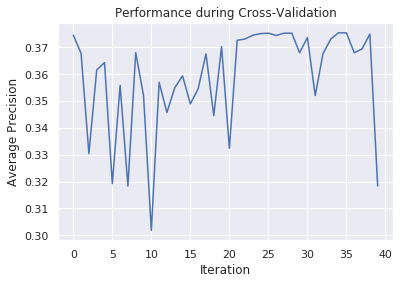

In [57]:
# Load model
svm_poly_hp = joblib.load('saved_models/svm_poly_hp.joblib')

# Print and save average precision; save predictions
average_precisions['svm_poly'] = return_save_ap(
    svm_poly_hp, 'svm_poly_hp', X_test, y_test,
    X_train=X_train, y_train=y_train,
    validation_plot=True)

The average precision of 0.3925 with the polynomial kernel is again very similar (though on the lower end) of what we got before (except to XGBoost, which is far ahead).  

The next step is to adjust the decision threshold.

In [ ]:
# Load predicted probability
y_score_svm_poly = joblib.load('predictions_test/y_score_svm_poly_hp.joblib')

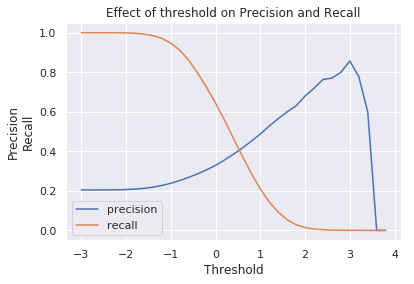

In [54]:
# Plot effect of decision threshold
plot_threshold(y_score_svm_poly, thresholds=np.arange(-3,4,0.2))

We choose a threshold of 0.35, which gives us a recall of 0.49 and a precision of 0.38.

In [55]:
# Make hard predictions
y_svm_poly_2 = custom_prediction(y_score_svm_poly, 0.35)
# Save new predictions to disk
joblib.dump(y_svm_poly_2, 'predictions_test/y_svm_poly_2.joblib')

['predictions_test/y_svm_poly_2.joblib']

In [56]:
# Get classification report 
print(classification_report(y_test, y_svm_poly_2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82    122083
           1       0.38      0.49      0.43     31416

   micro avg       0.73      0.73      0.73    153499
   macro avg       0.62      0.64      0.62    153499
weighted avg       0.76      0.73      0.74    153499



## Save/load average precision score

 Now let's save the average precision scores, so we can access them in the final notebook.

In [60]:
# Save
joblib.dump(average_precisions, 'saved_models/average_precisions.joblib')

['saved_models/average_precisions.joblib']

In the next notebook, we will create an ensemble from these predictions (implemented as a hard-working classifier). 